In [15]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# problem domain
def y(x,E,w,I,a):
    return w*x**2*(a-x)**2/(24*E*I)
#Parameters
E=127e9
t=0.000935
b=50e-3
I=b*t**3/12
a=0.027487
L=a
rng = np.random.default_rng(seed=42)
x=rng.uniform(0, L, 1000)
x_train = x
q=860210.526316
y_train = y(x_train,E,q,I,L)

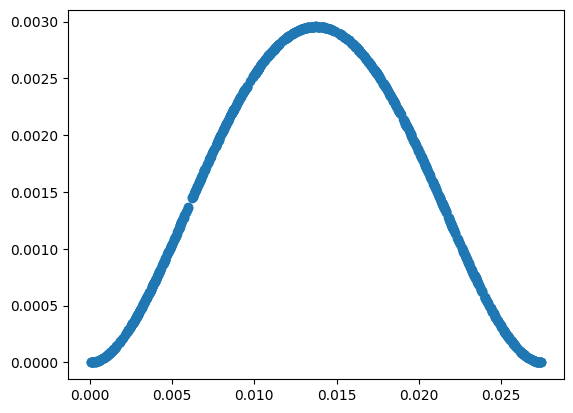

In [17]:
plt.plot(x_train, y_train, 'o')

In [18]:
#Scale data
x_max=x_train.max()
y_max=y_train.max()
x_scaled = x_train / x_max
y_scaled = y_train / y_max


In [19]:
# NN architecture / training
hidden_layers = [50, 50, 50, 50]
activation = nn.Tanh  

In [20]:
# ====== MLP builder ======
def build_mlp(input_dim, output_dim, hidden_layers, act=nn.Tanh):
    layers = []
    prev = input_dim
    for h in hidden_layers:
        layers.append(nn.Linear(prev, h))
        layers.append(act())
        prev = h
    layers.append(nn.Linear(prev, output_dim))
    return nn.Sequential(*layers)
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization

# ====== redes separadas para w, theta, M, Q ======
w_net = build_mlp(1, 1, hidden_layers, act=activation)
theta_net = build_mlp(1, 1, hidden_layers, act=activation)
M_net = build_mlp(1, 1, hidden_layers, act=activation)
Q_net = build_mlp(1, 2, hidden_layers, act=activation) #Q tiene 2 salidas (Q y q)
init_xavier(w_net, retrain)
init_xavier(theta_net, retrain)
init_xavier(M_net, retrain)
init_xavier(Q_net, retrain)
nets = [w_net, theta_net, M_net, Q_net]

In [21]:
seed = 1234
lr = 1e-3
torch.manual_seed(seed)
np.random.seed(seed)

In [22]:
# ====== derivative function ======
def deriv(y, x, order=1):
    # y: tensor scalar output; x: tensor inputs (requires_grad=True)
    assert x.requires_grad, "x must require_grad"
    out = y
    for i in range(order):
        grads = autograd.grad(outputs=out, inputs=x,
                              grad_outputs=torch.ones_like(out),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
        out = grads
    return out

In [23]:
x_coll = torch.tensor(x_scaled.astype(np.float32),dtype=torch.float32, requires_grad=True).reshape(-1,1)
#Boundary points
x_b0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True).reshape(-1,1)
x_bL = torch.tensor([[1.0]], dtype=torch.float32, requires_grad=True).reshape(-1,1)


In [24]:
def pinn_loss(nets, x_in, x_b0, x_bL,y_true):
    w_pred = nets[0](x_in).reshape(-1,1)          # w(x)
    theta_pred = nets[1](x_in).reshape(-1,1)      # theta(x)
    M_pred = nets[2](x_in).reshape(-1,1)          # M(x)
    Q_pred = nets[3](x_in)[:,0].reshape(-1,1)          # Q(x)

    dw_dx = deriv(w_pred, x_in, order=1)
    Lw = dw_dx - theta_pred #First equation

    dtheta_dx = deriv(theta_pred, x_in, order=1)
    Ltheta = dtheta_dx + M_pred #Second equation
    
    # dM/dx + Q = 0  => L_M
    dM_dx = deriv(M_pred, x_in, order=1)
    LM = dM_dx + Q_pred #Third equation


    dQ_dx = deriv(Q_pred, x_in, order=1)
    q_vals = nets[3](x_in)[:,1].reshape(-1,1)   # Optimize parameter
    LQ = dQ_dx + q_vals #Fourth equation

    # PDE residual norms (MSE)
    loss_w = torch.mean(Lw**2)
    loss_theta = torch.mean(Ltheta**2)
    loss_M = torch.mean(LM**2)
    loss_Q = torch.mean(LQ**2)
    # Boundary conditions w(0)=0, w(L)=0, theta(0)=0, theta(L)=0
    w_b0_pred = nets[0](x_b0)
    w_bL_pred = nets[0](x_bL)
    theta_b0_pred = nets[1](x_b0)
    theta_bL_pred = nets[1](x_bL)

    loss_bcs= torch.mean(w_b0_pred**2) + torch.mean(w_bL_pred**2) + \
                torch.mean(theta_b0_pred**2) + torch.mean(theta_bL_pred**2)
    loss_mse= torch.mean((w_pred - y_true)**2)
    total = loss_w + loss_theta + loss_M + loss_Q + loss_bcs + loss_mse
    return total, dict(loss_w=loss_w.item(), loss_theta=loss_theta.item(),
                       loss_M=loss_M.item(), loss_Q=loss_Q.item(), loss_bcs=loss_bcs.item(), loss_mse=loss_mse.item(),dQ_dx=dQ_dx.mean().item())

In [25]:
n_epochs = 5000
use_lbfgs = True
# ====== optimizer ======
params = []
for net in nets:
    params += list(net.parameters())

optimizer = torch.optim.Adam(params, lr=lr)

# Optional L-BFGS closure
if use_lbfgs:
    lbfgs_optimizer = torch.optim.LBFGS(params, max_iter=500, tolerance_grad=1e-9, tolerance_change=1e-12, history_size=50)

# ====== TRAINING LOOP ======
loss_history = []
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad()
    y_true=torch.tensor(y_scaled.astype(np.float32),dtype=torch.float32).reshape(-1,1)
    total_loss, comp = pinn_loss(nets, x_coll, x_b0, x_bL, y_true)
    total_loss.backward()
    optimizer.step()

    loss_history.append(total_loss.item())

    if epoch % 500 == 0 or epoch == 1:
        print(f"Epoch {epoch:6d} | Loss {total_loss.item():.3e} | components: {comp}")

    # optionally run L-BFGS every few thousand epochs or at the end
    if use_lbfgs and epoch % 4000 == 0:
        def closure():
            lbfgs_optimizer.zero_grad()
            loss_lb, _ = pinn_loss(nets, x_coll, x_b0, x_bL,y_true)
            loss_lb.backward()
            return loss_lb
        print("  --> Running L-BFGS refinement ...")
        lbfgs_optimizer.step(closure)


Epoch      1 | Loss 1.129e+00 | components: {'loss_w': 0.008555391803383827, 'loss_theta': 0.027205344289541245, 'loss_M': 0.02707352116703987, 'loss_Q': 0.6132926344871521, 'loss_bcs': 0.018401194363832474, 'loss_mse': 0.4345962405204773, 'dQ_dx': -0.09669456630945206}
Epoch    500 | Loss 2.809e-01 | components: {'loss_w': 0.01814824715256691, 'loss_theta': 0.0003621262439992279, 'loss_M': 1.919155147334095e-05, 'loss_Q': 4.998811164114159e-06, 'loss_bcs': 0.05404127016663551, 'loss_mse': 0.2083234190940857, 'dQ_dx': 0.19894281029701233}
Epoch   1000 | Loss 2.798e-01 | components: {'loss_w': 0.018077943474054337, 'loss_theta': 0.0003636913315858692, 'loss_M': 5.6235294323414564e-05, 'loss_Q': 5.217817943048431e-06, 'loss_bcs': 0.053860314190387726, 'loss_mse': 0.2074737697839737, 'dQ_dx': 0.9135571718215942}
Epoch   1500 | Loss 2.934e-01 | components: {'loss_w': 0.0209656935185194, 'loss_theta': 0.0010918539483100176, 'loss_M': 0.006674090400338173, 'loss_Q': 0.006707325112074614, 'lo

In [26]:
E,-q,I,L

(127000000000.0, -860210.526316, 3.405834895833333e-12, 0.027487)

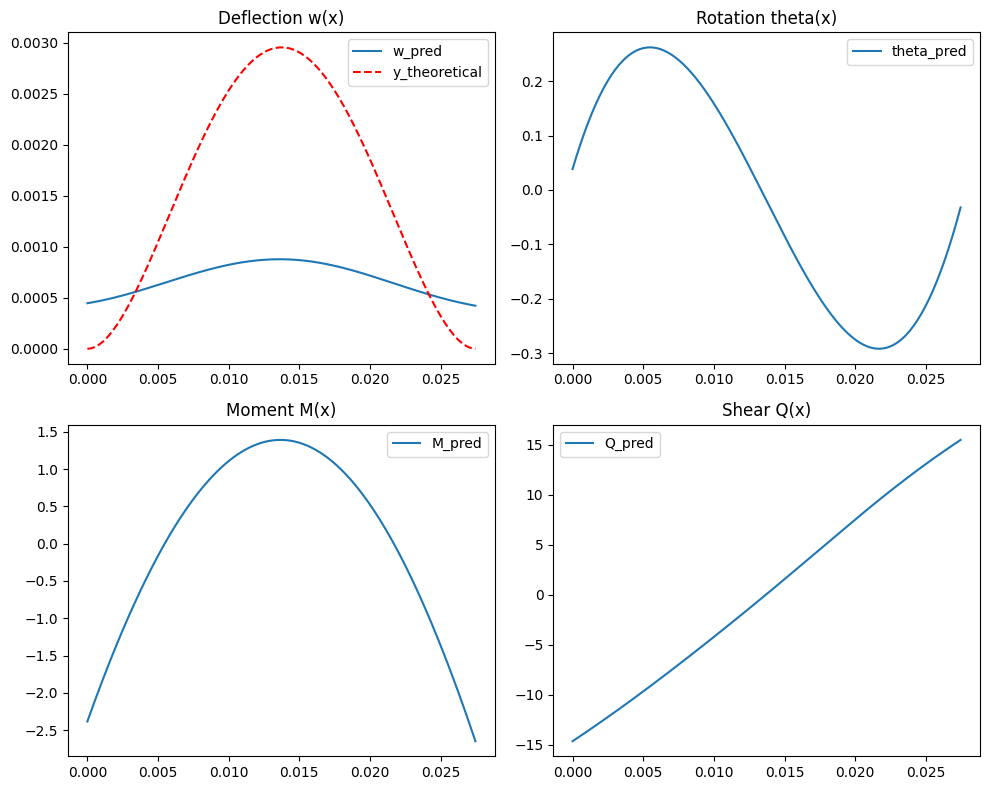

In [27]:
# ====== Results: evaluate on dense grid and plot ======
x_plot = torch.tensor(np.linspace(0, 1, 200).reshape(-1,1).astype(np.float32), requires_grad=True)
with torch.no_grad():
    w_pred_plot = w_net(x_plot).cpu().numpy().flatten()
    theta_pred_plot = theta_net(x_plot).cpu().numpy().flatten()
    M_pred_plot = M_net(x_plot).cpu().numpy().flatten()
    Q_pred_plot = Q_net(x_plot)[:,0].cpu().numpy().flatten()
x_np = x_plot.cpu().detach().numpy()
x_np=x_np*x_max  # Scale back to original domain
w_pred_plot=w_pred_plot*y_max  # Scale back to original domain
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(x_np, w_pred_plot, label='w_pred')
plt.plot(x_np, y(x_np,E,q,I,L), 'r--', label='y_theoretical')
plt.title('Deflection w(x)')
plt.legend()
plt.subplot(2,2,2)
plt.plot(x_np, theta_pred_plot, label='theta_pred')
plt.title('Rotation theta(x)')
plt.legend()
plt.subplot(2,2,3)
plt.plot(x_np, M_pred_plot, label='M_pred')
plt.title('Moment M(x)')
plt.legend()
plt.subplot(2,2,4)
plt.plot(x_np, Q_pred_plot, label='Q_pred')
plt.title('Shear Q(x)')
plt.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Training Loss History')

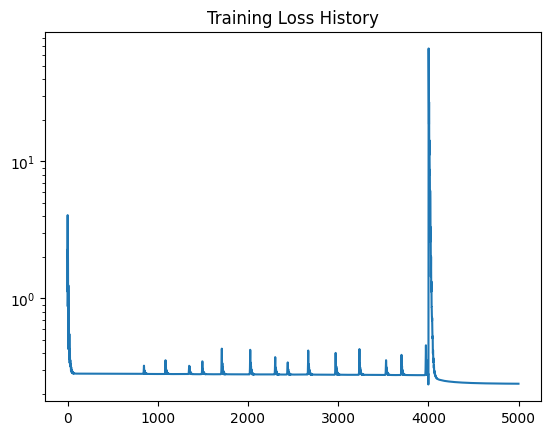

In [28]:
plt.semilogy(loss_history)
plt.title('Training Loss History')